# TCC

- Problema: localização de minérios
- Solução: aplicação de aprendizado de máquina com uso de dados de espectrometria e gravimetria para classificar locais com alta probabilidade de conter minérios
  - Minério de estudo: ferro

---
- Processamento:
  - Problemas: 
    - conversão de coordenadas para latitude/longitude e uso de 3 casas decimais para evitar perda de dados durante mesclagem de dados

  - Aprendizado de máquina:
    - desbalanceamento entre classes

---

Ref Github: https://github.com/lszam/mineralexp

In [1]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)
import shap
import folium
from branca.element import Figure

filterwarnings("ignore")

sys.tracebacklimit = 0

/home/renan/study/tcc_univesp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_projeto = Path(os.getcwd()).parent.absolute().parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc", "v1")
shp_dir = Path(data_dir, "shp")

## funções

In [3]:
def utm_to_latlon(
    df: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    utm_zone: int = 22,
    southern_hemisphere: bool = True,
) -> pd.DataFrame:
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj="utm", zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj="latlong", datum="WGS84")

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df["longitude"] = lon
    df["latitude"] = lat

    df["longitude"] = df["longitude"].round(4)
    df["latitude"] = df["latitude"].round(4)

    return df


def convert_shapefile_to_latlon(shapefile_path: Path) -> gpd.GeoDataFrame:
    """
    Read a shapefile and convert coordinates to latitude/longitude (WGS84)

    Parameters:
    - shapefile_path: path for the shapefile

    Returns:
    GeoDataFrame
    """
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = "+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    if not os.path.basename(shapefile_path) == "estruturas_ln.shp":
        gdf['longitude'] = gdf.geometry.x
        gdf['latitude'] = gdf.geometry.y
    return gdf


def criar_dataframe_base(df_merge_data: pd.DataFrame, df_mineral: pd.DataFrame) -> pd.DataFrame:
    """Mesclar dados de espectrometria, gravimetria e minério com base em coordenadas geográficas

    Args:
        df_merge_data (pd.DataFrame): dados de espectrometria e gravimetria
        df_mineral (pd.DataFrame): dados de minérios

    Returns:
        pd.DataFrame: dataframe com mesclagem de dados baseado em coordenadas geográficas
    """
    df_mineral = pd.merge(df_merge_data, df_mineral, how="outer", on=["longitude", "latitude"])
    df_mineral = df_mineral.fillna(0)
    df_mineral["ocorrencia"] = df_mineral["ocorrencia"].astype(np.int16)
    return df_mineral


def clusterizar_coordenadas_geograficas(df: pd.DataFrame, n_clusters: np.int16 = 8) -> pd.DataFrame:
    """Aplica clusterização nas coordenadas geográficas para modelo de aprendizado de máquina,
    como feature engineering

    Args:
        df (pd.DataFrame): dataframe com dados de coordenadas geográficas
        n_clusters (np.int16, optional): número de clusters. Defaults to 8.

    Returns:
        pd.DataFrame: dataframe com clusters de coordenadas
    """
    coords = df[["longitude", "latitude"]].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df["geo_cluster"] = kmeans.labels_
    dict_map_idx_lon = dict(zip(df.index, df["longitude"]))
    dict_map_idx_lat = dict(zip(df.index, df["latitude"]))
    df = df.drop(["longitude", "latitude"], axis=1)
    return df, dict_map_idx_lon, dict_map_idx_lat


def split_data(df: pd.DataFrame, test_size: np.float16 = 0.3) -> tuple:
    """Divide dados de treino e teste

    Args:
        df (pd.DataFrame): dataframe com dados
        test_size (np.float16, optional): tamanho dos dados de teste. Defaults to 0.3.

    Returns:
        tuple: _description_
    """
    X = df.drop(["ocorrencia"], axis=1)
    y = df["ocorrencia"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=420,
        stratify=y,  # dados desbalanceados
    )

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class balance - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test


def pipeline_ml(
    models: dict,
    cv: StratifiedKFold,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
) -> dict:
    """Pipeline para modelos de aprendizado de máquina, realizando treinamento com validação cruzada e avaliação

    Args:
        models (dict): dicionário com modelos
        cv (StratifiedKFold): validação cruzada
        X_train (np.array): array de dados independentes de treino
        X_test (np.array): array de dados independentes de teste
        y_train (np.array): array de dados dependentes de treino
        y_test (np.array): array de dados dependentes de teste
    """
    results = {}
    for name, model in models.items():
        start_train = time.perf_counter()

        # Create pipeline (scale for logistic regression)
        if name == "Logistic Regression":
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = model

        # Cross-validation
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipe.fit(X_train, y_train)

        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {"model": pipe, "cv_mean_auc": cv_scores.mean(), "cv_std_auc": cv_scores.std()}

        print(f"{name} - CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Evaluate on test set
        if hasattr(pipe, "predict_proba"):
            evaluate_model(pipe, X_test, y_test)

    return results


def evaluate_model(model, X_test: np.array, y_test: np.array) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


def pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test):
    results = {}
    # Training and evaluation
    for name, pipeline in pipelines.items():
        print(f"\n=== Training {name} ===")

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        print(f"CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Test set evaluation
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
        print(f"Test F1: {res['test_f1']:.3f}")
        print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

## leitura e processamento

- leitura dos shapefiles com ocorrências de metais/minas

In [4]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))
# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))
# estruturas = gpd.read_file(Path(shp_dir, 'estruturas_ln.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
ouro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Au.shp"))
# cobre = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Cu.shp'))
ferro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Fe.shp"))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
# niquel = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Ni.shp'))
# chumbo = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Pb.shp'))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, "minas.shp"))

estruturas = convert_shapefile_to_latlon(Path(shp_dir, "estruturas_ln.shp"))

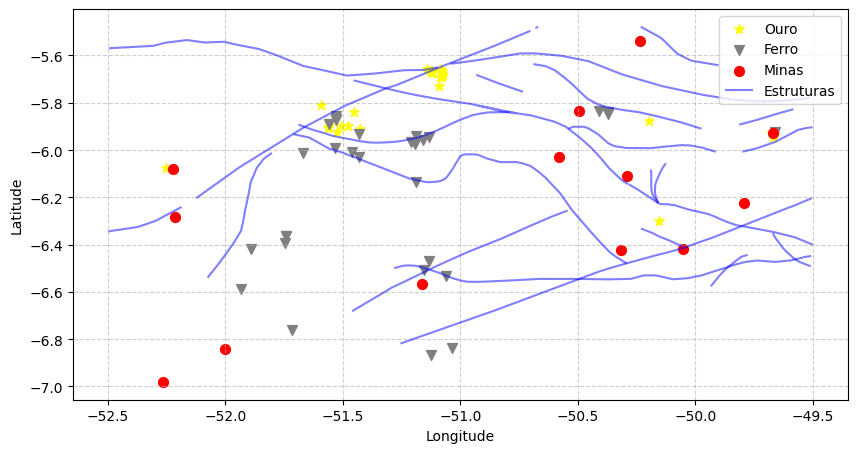

In [5]:
# https://matplotlib.org/stable/api/markers_api.html
fig, ax = plt.subplots(figsize=(10, 10))
ouro.plot(ax=ax, color="yellow", marker="*", markersize=50, label="Ouro")
ferro.plot(ax=ax, color="gray", marker="v", markersize=50, label="Ferro")
minas.plot(ax=ax, color="red", marker="o", markersize=50, label="Minas")
estruturas.plot(ax=ax, color='blue', alpha=0.5, label='Estruturas')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, alpha=0.6, linestyle="--")
plt.legend()
plt.show()

In [6]:
df_minas = pd.DataFrame(minas)
df_minas = df_minas[["longitude", "latitude"]]
df_minas["longitude"] = df_minas["longitude"].round(4)
df_minas["latitude"] = df_minas["latitude"].round(4)

df_minas.head(3)

,longitude,latitude
0,-52.2160,-6.2850
1,-52.2204,-6.0792
2,-51.1648,-6.5678


In [7]:
df_minerio = pd.DataFrame(ferro)
df_minerio = df_minerio[["longitude", "latitude"]]
df_minerio["longitude"] = df_minerio["longitude"].round(4)
df_minerio["latitude"] = df_minerio["latitude"].round(4)
df_minerio["ocorrencia"] = 1

df_minerio.head(3)

,longitude,latitude,ocorrencia
0,-51.5287,-5.8690,1
1,-51.5308,-5.8738,1
2,-51.0592,-6.5308,1


- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [8]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col="XUTM", y_col="YUTM")
spec_data.head(3)

,XUTM,YUTM,FatorF,Kd,Ud,longitude,latitude
0,279545.71875,9101977.0,0.001366,-71.005653,-0.349341,-53.0007,-8.1192
1,279681.28125,9101978.0,0.003305,-28.235151,-0.366232,-52.9995,-8.1192
2,279816.87500,9101979.0,0.005131,-17.356588,-0.394505,-52.9982,-8.1192


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: Gravity residual at 190km (possibly Bouguer anomaly)
    - grav_residual100km: Gravity residual at 100km
    - maq_asvi: Likely some gravity-related index or processed value
    - maq_qt: Another gravity-related metric, possibly quality or quantity measure

In [9]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col="X", y_col="Y")
grav_data.head(3)

,X,Y,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,453679.25,9102751.0,0.000501,-1.943505,67.472176,0.008145,-51.4205,-8.1169
1,454429.25,9102751.0,0.000573,-1.592606,64.604439,0.008208,-51.4136,-8.1169
2,455179.25,9102751.0,0.000563,-1.343595,62.171368,0.008150,-51.4068,-8.1169


- mesclar dfs com dados de gravimetria e espectrometria

In [10]:
df_merge_data = pd.merge(spec_data, grav_data, how="inner", on=["longitude", "latitude"]).drop(
    ["X", "Y", "XUTM", "YUTM"], axis=1
)
df_merge_data = df_merge_data[
    [
        "longitude",
        "latitude",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
    ]
]
df_merge_data.head(3)

,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt
0,-50.4878,-8.1168,0.694452,0.677858,0.362031,0.001244,7.376926,96.937653,0.010946
1,-50.0930,-8.1094,0.733680,0.439271,0.202883,0.000644,-13.605432,264.709503,0.026035
2,-49.6846,-8.1082,0.044766,-1.531327,0.273447,0.001481,-11.418680,34.700977,0.011797


- criar dataframes base para aprendizado de máquina

In [11]:
df_minerio_merge = criar_dataframe_base(df_merge_data=df_merge_data, df_mineral=df_minerio)
df_minerio_merge.head(3)

,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-53.0056,-7.9766,0.035678,0.062444,-1.777633,0.000508,6.253668,74.152176,0.007543,0
1,-53.0032,-5.7933,0.039337,0.585360,-2.711142,0.000181,-6.679170,45.226242,0.007310,0
2,-53.0032,-5.7798,0.024151,0.514961,-4.404083,0.000321,-6.968885,40.509464,0.008214,0


In [12]:
print(f"Dados de espectrometria: {spec_data.shape[0]}")
print(f"Dados de gravimetria: {grav_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Mesclagem com ouro (espec + gravim + ouro) : {df_minerio_merge.shape[0]}")

Dados de espectrometria: 7672496
Dados de gravimetria: 247298
Mesclagem de dados (espec + gravim): 1662
Mesclagem com ouro (espec + gravim + ouro) : 1694


- clusterização de coordenadas geográficas
  - n_clusters = default 8 (tutorial) -> parametrizado

In [13]:
df_minerio_merge, dict_map_idx_lon, dict_map_idx_lat = clusterizar_coordenadas_geograficas(df=df_minerio_merge)

## aprendizado de máquina

### split treino-teste

- split padrão -> 70% treino e 30% teste

In [14]:
X_train, X_test, y_train, y_test = split_data(df=df_minerio_merge)

Train shape: (1185, 8), Test shape: (509, 8)
Class balance - Train: 1.86%, Test: 1.96%


### pipeline

In [15]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric="logloss"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = pipeline_ml(models, cv, X_train, X_test, y_train, y_test)

Tempo total de treino Random Forest: 0.06 min
Random Forest - CV AUC: 1.000 (±0.000)
ROC-AUC: 1.000
F1 Score: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00        10

    accuracy                           1.00       509
   macro avg       1.00      1.00      1.00       509
weighted avg       1.00      1.00      1.00       509

Tempo total de treino Logistic Regression: 0.02 min
Logistic Regression - CV AUC: 0.999 (±0.002)
ROC-AUC: 0.998
F1 Score: 0.842

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       0.89      0.80      0.84        10

    accuracy                           0.99       509
   macro avg       0.94      0.90      0.92       509
weighted avg       0.99      0.99      0.99       509

Tempo total de treino XGBoost: 0.02 min
XGBoost - CV A

1. Desempenho dos Modelos

    - Random Forest e XGBoost obtiveram desempenho perfeito em todas as métricas:

        - AUC-ROC = 1.0, F1-Score = 1.0 (classificação impecável para ambas as classes).

        - Precisão e Recall = 100% (sem erros).

    - Regressão Logística teve um desempenho ligeiramente inferior na classe minoritária (1):

        - F1-Score = 0.842 (precisão = 0.89, recall = 0.80).

        - AUC-ROC = 0.998 (ainda excelente, mas não perfeito).

2. Tempo de Treinamento

    - Todos os modelos foram extremamente rápidos (< 0.06 min).

        - Regressão Logística e XGBoost foram os mais rápidos (0.02 min).

        - Random Forest um pouco mais lento (0.06 min), mas ainda muito eficiente.

3. Possíveis Problemas

    - Overfitting:

        - Random Forest e XGBoost com AUC = 1.0 podem estar memorizando os dados, especialmente porque a classe 1 tem apenas 10 amostras (desequilíbrio).

    - Generalização da Regressão Logística:

        - Seu F1-Score (0.842) sugere um comportamento mais realista, mas ainda há espaço para melhorias na classe minoritária.

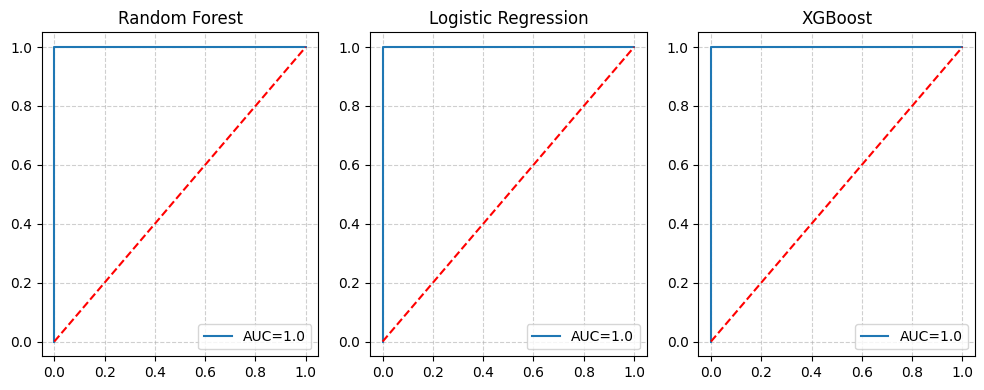

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for mdl, ax in zip(models.keys(), axs.flatten()):
    y_proba = models[mdl].predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # plot
    ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
    ax.plot([0, 1], [0, 1], "r--")
    ax.legend()
    ax.grid(visible=True, alpha=0.6, linestyle='--')
    ax.set_title(mdl)
plt.tight_layout()
plt.show()

### pipeline undersampling

In [18]:
models = {
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        penalty='l2',
        solver='lbfgs'
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
    )
}

# Create pipelines with undersampling
pipelines = {}
for name, model in models.items():
    if name == "Logistic Regression":
        # Add StandardScaler for Logistic Regression
        pipelines[name] = make_pipeline(
            RandomUnderSampler(random_state=42),
            StandardScaler(),
            model
        )
    else:
        pipelines[name] = make_pipeline(
            RandomUnderSampler(random_state=42),
            model
        )

results_unders = pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test)


=== Training Random Forest ===
CV AUC: 1.000 (±0.000)
Test ROC-AUC: 1.000
Test F1 Score: 1.000
Test Average Precision: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00        10

    accuracy                           1.00       509
   macro avg       1.00      1.00      1.00       509
weighted avg       1.00      1.00      1.00       509

Optimal Decision Threshold: 1.000

=== Training Logistic Regression ===
CV AUC: 0.996 (±0.002)
Test ROC-AUC: 0.998
Test F1 Score: 0.606
Test Average Precision: 0.851

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       499
           1       0.43      1.00      0.61        10

    accuracy                           0.97       509
   macro avg       0.72      0.99      0.80       509
weighted avg       0.99      0.97      0.98       509

Optima

1. Desempenho dos Modelos

    - Random Forest manteve desempenho perfeito (AUC = 1.0, F1 = 1.0), mas ainda suspeito de overfitting devido ao desbalanceamento (10 amostras da classe 1).

    - Regressão Logística e XGBoost tiveram:

        - F1-Score moderado (~0.61-0.63) para a classe minoritária.

        - Recall = 1.00 (capturou todos os positivos), mas precisão baixa (~0.43-0.45) (muitos falsos positivos).

        - AUC-ROC alto (> 0.99), indicando boa separação, mas limiares otimizados priorizam recall.

2. Thresholds Ótimos

    - Random Forest (1.0) e XGBoost (0.998): Thresholds altos → só classificam como positivo com máxima confiança.

    - Regressão Logística (0.848): Threshold mais baixo → maior recall, porém mais falsos positivos.

Próximos passos:

    - Validar em um conjunto de teste independente
    - Testar técnicas como SMOTE (em vez de undersampling) ou ajustar pesos de classe
    - Usar validação cruzada estratificada para garantir robustez

- fazendo uso apenas do modelo Random Forest

In [19]:
best_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

pipeline = make_pipeline(RandomUnderSampler(random_state=42), best_model)
pipeline.fit(X_train, y_train)

# Get probabilities for class 1
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Apply threshold
y_pred_custom = (y_proba >= 0.990).astype(int)

In [20]:
print(f"Class 0 (No Gold): {sum(y_pred_custom == 0)}")
print(f"Class 1 (Gold): {sum(y_pred_custom == 1)}")

Class 0 (No Gold): 499
Class 1 (Gold): 10


- matriz de confusão

[[TP, FP],
[FN, TN]]

In [21]:
print(confusion_matrix(y_test, y_pred_custom))

[[499   0]
 [  0  10]]


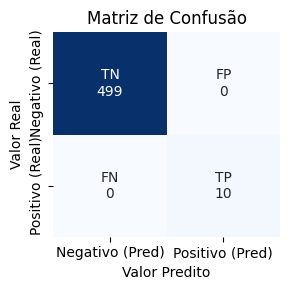

In [22]:
cm = confusion_matrix(y_test, y_pred_custom)
labels = ["TN", "FP", "FN", "TP"]
counts = [f"{label}\n{value}" for label, value in zip(labels, cm.flatten())]
counts = np.array(counts).reshape(2, 2)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=counts, fmt='', cmap="Blues", cbar=False,
            xticklabels=['Negativo (Pred)', 'Positivo (Pred)'],
            yticklabels=['Negativo (Real)', 'Positivo (Real)'])
plt.title("Matriz de Confusão", fontsize=12)
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.tight_layout()
plt.show()

In [23]:
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00        10

    accuracy                           1.00       509
   macro avg       1.00      1.00      1.00       509
weighted avg       1.00      1.00      1.00       509



- feature importance do modelo

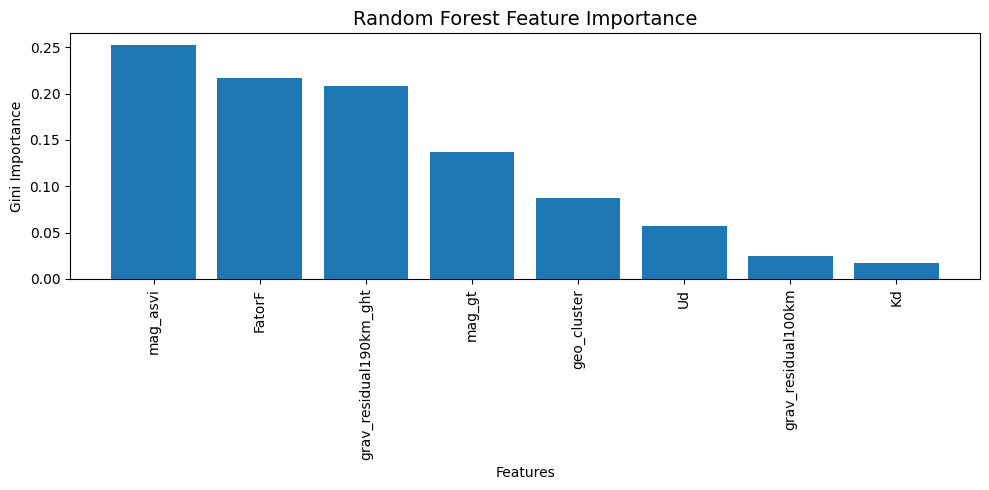

In [24]:
rf_model = pipeline.named_steps['randomforestclassifier']

importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importance", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

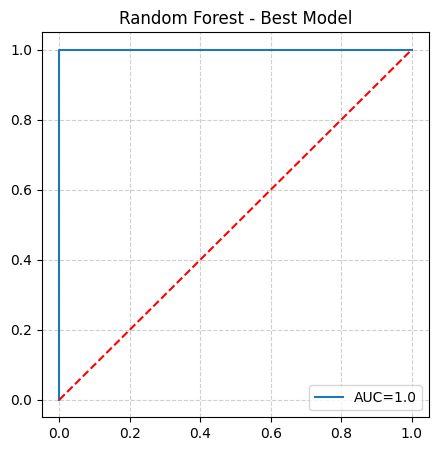

In [25]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
ax.plot([0, 1], [0, 1], "r--")
ax.legend()
ax.set_title('Random Forest - Best Model')
ax.grid(visible=True, alpha=0.6, linestyle='--')
plt.show()

### SHAP

Ref: https://shap.readthedocs.io/en/latest/

Resampled data shape: (44, 8)
All SHAP values shape: (44, 8, 2)
SHAP values for class 1: (44, 8)


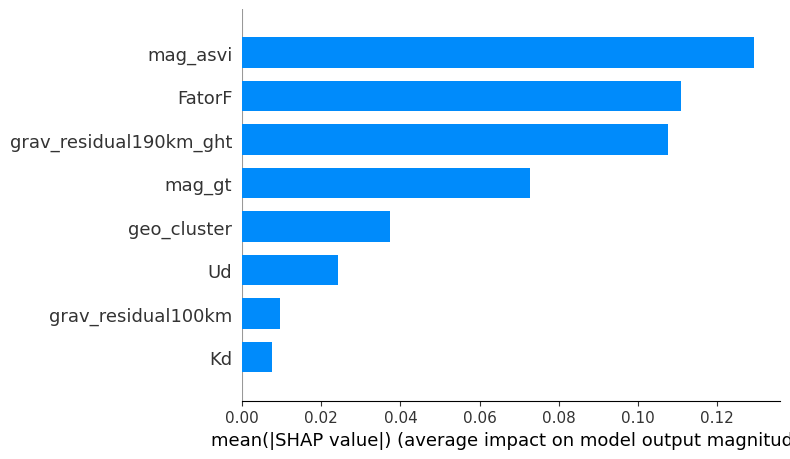

In [26]:
undersampler = pipeline.named_steps['randomundersampler']
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

model = pipeline.named_steps['randomforestclassifier']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_resampled)

print(f"Resampled data shape: {X_resampled.shape}")
print(f"All SHAP values shape: {np.array(shap_values).shape}")
print(f"SHAP values for class 1: {shap_values[:,:,1].shape}")

shap.summary_plot(
    shap_values[:, :, 1],
    pd.DataFrame(X_resampled, columns=X_train.columns),
    feature_names=X_train.columns.tolist(),
    plot_type="bar",
)

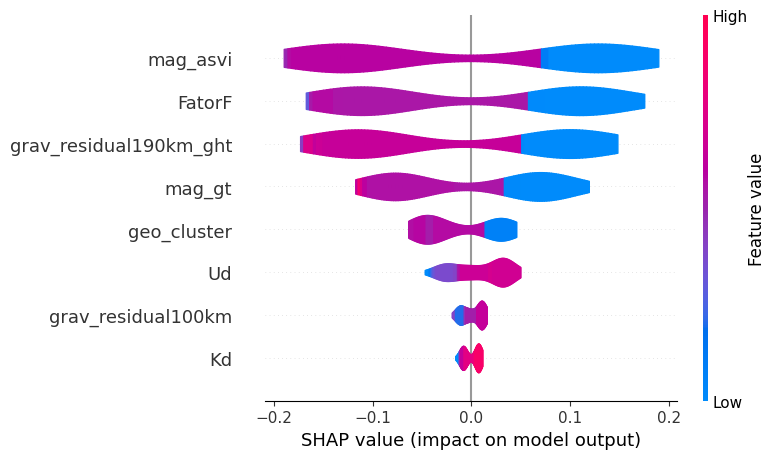

In [27]:
shap.summary_plot(
    shap_values[:, :, 1], pd.DataFrame(X_resampled, columns=X_train.columns), plot_type="violin"
)

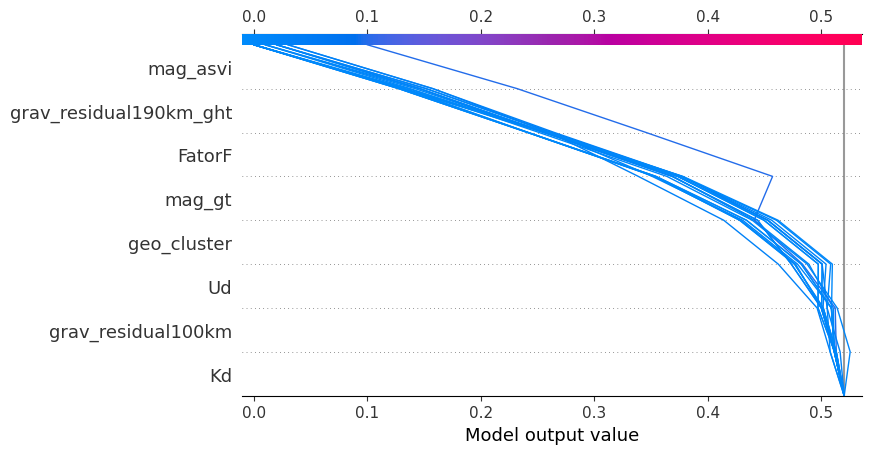

In [28]:
shap.decision_plot(
    explainer.expected_value[1], shap_values[:, :, 1][:20], feature_names=X_train.columns.tolist()
)

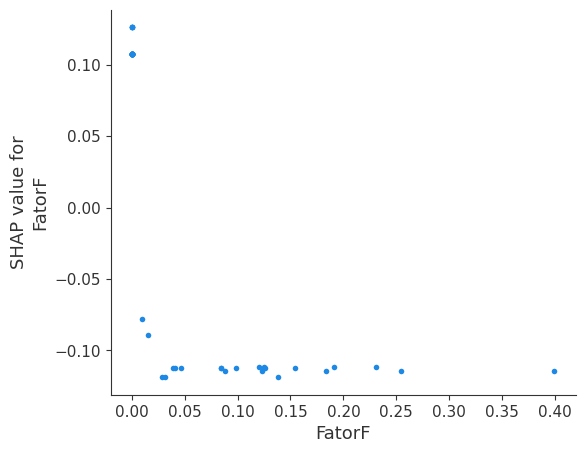

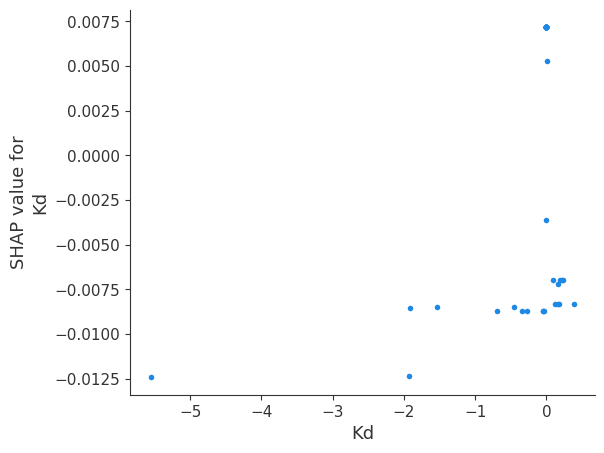

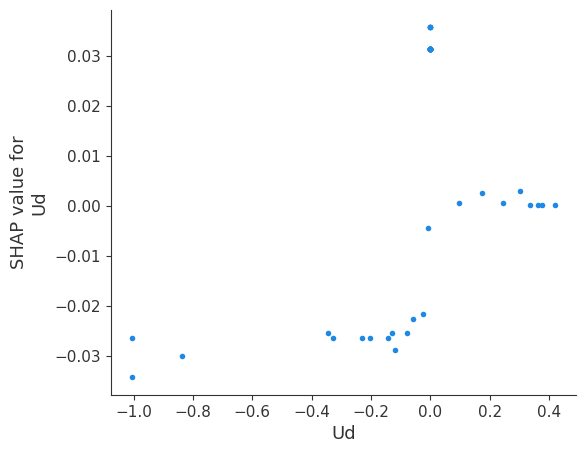

In [29]:
for feature in X_train.columns[:3]:  # Top 3 features
    shap.dependence_plot(
        feature,
        shap_values[:, :, 1],
        pd.DataFrame(X_resampled, columns=X_train.columns),
        interaction_index=None,
    )

### Mapa

In [30]:
coord_df = pd.DataFrame.from_dict(dict_map_idx_lon, orient='index')
coord_df['latitude'] = dict_map_idx_lat
coord_df.columns = ['longitude', 'latitude']
coord_df.head(3)

,longitude,latitude
0,-53.0056,-7.9766
1,-53.0032,-5.7933
2,-53.0032,-5.7798


In [31]:
results = X_test.copy()
results['probability'] = y_proba
results['prediction'] = y_pred_custom
results.head(3)

,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,geo_cluster,probability,prediction
378,0.011097,-8.610280,-0.474040,0.000363,5.010684,28.791523,0.024647,2,0.04,0
379,0.093535,-0.596903,0.039462,0.000802,7.581067,40.841866,0.010751,2,0.02,0
190,0.035848,-2.376287,0.146509,0.000333,-3.591511,68.120934,0.011700,2,0.00,0


In [32]:
results = pd.merge(results, coord_df, left_index=True, right_index=True, how='inner')
results.head(3)

,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,geo_cluster,probability,prediction,longitude,latitude
378,0.011097,-8.610280,-0.474040,0.000363,5.010684,28.791523,0.024647,2,0.04,0,-52.2369,-7.9864
379,0.093535,-0.596903,0.039462,0.000802,7.581067,40.841866,0.010751,2,0.02,0,-52.2356,-7.5387
190,0.035848,-2.376287,0.146509,0.000333,-3.591511,68.120934,0.011700,2,0.00,0,-52.6083,-7.2324


In [33]:
mineral_locations = results[results['prediction'] == 1]
print(f"Locais com alta confiança de ouro: {len(mineral_locations)}")

Locais com alta confiança de ouro: 10


In [34]:
# Optimal Decision Threshold: 0.990
mineral_locations_thresh = results[results['prediction'] >= 0.990]
print(f"Locais com alta confiança de ouro: {len(mineral_locations_thresh)}")

Locais com alta confiança de ouro: 10


In [35]:
# https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html
fig = Figure(width=700, height=600)

m = folium.Map(
    location=[mineral_locations["latitude"].mean(), mineral_locations["longitude"].mean()],
    zoom_start=7,
)

for _, row in df_minas.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="red", fill=True, tooltip="Mina"
    ).add_to(m)


for _, row in df_minerio.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="black", fill=True, tooltip="Ferro"
    ).add_to(m)


for _, row in mineral_locations.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color="gray",
        fill=True,
        tooltip=f"Ferro Prob: {row['probability']:.3f}",
    ).add_to(m)


fig.add_child(m)